In [1]:
# install tensorflow
import tensorflow as tf

# notebook for an autoregressive (AR) model 

this model preforms linear regression forecasting on 1D timeseries data, as a precursor for learning recurrent neural networks (RNNs)

this notebook uses synthetic data, which is a good start to learning about the model under controlled circumstances 

In [2]:
# other imports
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

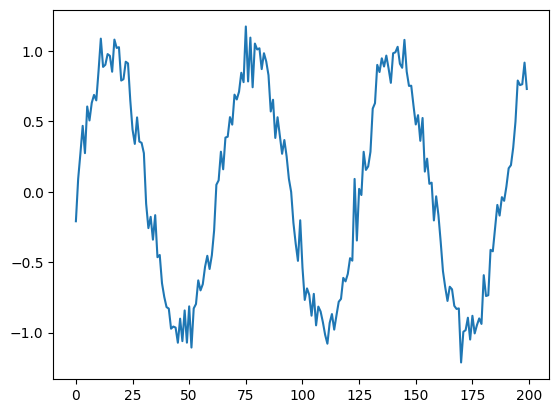

In [23]:
# begin with making original data
# this will be 1D timeseries data that follows a sine wave with 200 points

# first, no noise 
# series = np.sin(0.1*np.arange(200))

# second, with noise 
series = np.sin(0.1*np.arange(200)) + np.random.randn(200)*0.1

# plot the data
plt.plot(series)
plt.show()

In [24]:
# next, build the dataset that will be used for predictions
# we want to use 10 past values to predict the next value
T = 10

# start with X & Y as lists, then populate to arrays after
# alterative: preallocate space in np arrays, but the list > array is easier
X = []; Y = []

# we need to account for the data used to predict (10) and the target (1)
# so the final target index is len(series)-1, meaning t must go up to len(series)-T-1
for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

# cast lists to np arrays and print shape 
X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print('X.shape:', X.shape, 'Y.shape:', Y.shape)

X.shape: (190, 10) Y.shape: (190,)


In [25]:
# now, build the autoregressive linear model
# just an input layer, and a dense layer with one output & no activation
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i,x)

# compile
model.compile(loss='mse', optimizer=Adam(learning_rate=0.1))

# train
# important note with timeseries data: don't want to split up train and test data randomly (like sklearn)
# as forecasting model predicts the future
# so this model will train on the first half of the dataset, and test on second half 
r = model.fit(
    X[:-N//2], Y[:-N//2], 
    epochs=80, 
    validation_data=(X[-N//2:], Y[-N//2:])
)

Epoch 1/80
3/3 [==============================] - 1s 106ms/step - loss: 0.4735 - val_loss: 0.1961
Epoch 2/80
3/3 [==============================] - 0s 32ms/step - loss: 0.1670 - val_loss: 0.1042
Epoch 3/80
3/3 [==============================] - 0s 30ms/step - loss: 0.0884 - val_loss: 0.0831
Epoch 4/80
3/3 [==============================] - 0s 40ms/step - loss: 0.0780 - val_loss: 0.0758
Epoch 5/80
3/3 [==============================] - 0s 31ms/step - loss: 0.0784 - val_loss: 0.1105
Epoch 6/80
3/3 [==============================] - 0s 32ms/step - loss: 0.0928 - val_loss: 0.0863
Epoch 7/80
3/3 [==============================] - 0s 38ms/step - loss: 0.0737 - val_loss: 0.0582
Epoch 8/80
3/3 [==============================] - 0s 30ms/step - loss: 0.0577 - val_loss: 0.0424
Epoch 9/80
3/3 [==============================] - 0s 24ms/step - loss: 0.0413 - val_loss: 0.0436
Epoch 10/80
3/3 [==============================] - 0s 26ms/step - loss: 0.0411 - val_loss: 0.0373
Epoch 11/80
3/3 [===========

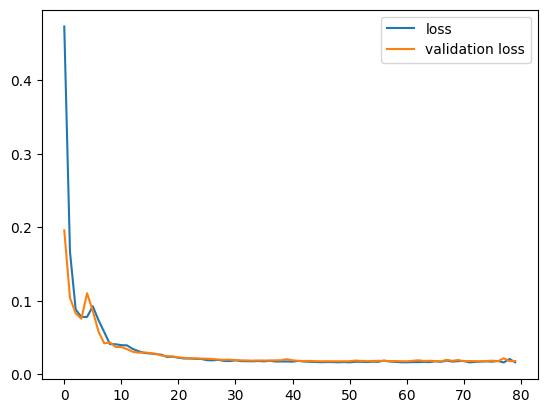

In [26]:
# plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [29]:
# next, we'll do a forecast doing the INCORRECT method using true targets
validation_target = Y[-N//2:]
validation_predictions = []

# index of the first validation input
i = -N//2

# remember: what goes into model.predict needs to be 2D, which X is
# but if we index it, it'll be a scalar
# model.predict returns an NxK output, and here N and K = 1
while len(validation_predictions) < len(validation_target): 
  p = model.predict(X[i].reshape(1,-1))[0,0]    # 1x1 array > scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

1/1 [==============================] - 0s 25ms/step


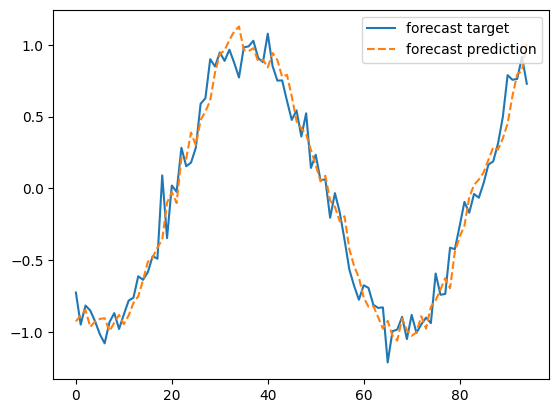

In [30]:
# now plot predictions vs target
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction', linestyle='dashed')
plt.legend()
plt.show()

# looks good (no noise), but this is still the wrong way to forecast

In [27]:
# now we'll do a forecast doing the CORRECT method 
# this way will forecast future values using only self-predictions
validation_target = Y[-N//2:]
validation_predictions = []

# last training input, will return a 1D array of length T
last_x = X[-N//2]

# the same process (keep the reshape)
while len(validation_predictions) < len(validation_target): 
  p = model.predict(last_x.reshape(1,-1))[0,0]    # 1x1 array > scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

  # make the new input - meaning we'll use the current prediction to make next prediction
  # so we'll shift all current values to the left and add the new prediction at the end
  # can do using np.roll()
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 24ms/step


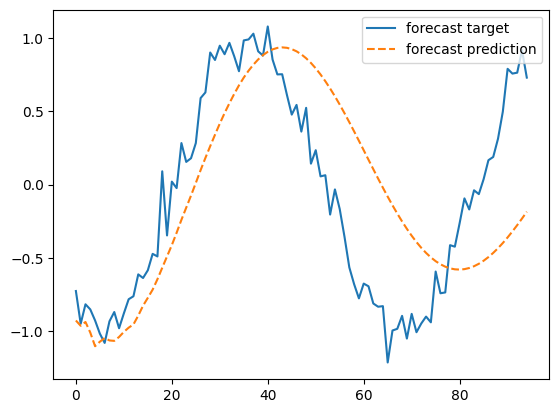

In [28]:
# re-plot predictions (correct way) vs target 
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction', linestyle='dashed')
plt.legend()
plt.show()

# using noise, it's not as good!